# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Understand batching for a recurrent neural network, and develop custom Dataset and DataLoaders with collate_fn to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

https://drive.google.com/file/d/10mLWQaG5wSaEY1GckQbmGFfbv2geq_Cv/view?usp=sharing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

torch.manual_seed(10)



## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
for line in open('SMSSpamCollection'):
    if line[0:3]=="ham":
        print("Non-spam ex: ", line)
        break
for line in open('SMSSpamCollection'):
    if line[0:4]=="spam":
        print("Spam ex: ", line)
        break

Non-spam ex:  ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Spam ex:  spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



The label value for a spam message is "spam", and the label value for a non-spam message is "ham".

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
texts = []
for line in open('SMSSpamCollection'):
    data = line.strip().split('\t')
    data.reverse()
    texts.append(data)

n_spam = sum(map(lambda d: 1 if d[1]=='spam' else 0, texts))
n_non_spam = sum(map(lambda d: 1 if d[1]!='spam' else 0, texts))
print('Number of spam messages:\t', n_spam)
print('Number of non-spam messages:\t', n_non_spam)

Number of spam messages:	 747
Number of non-spam messages:	 4827


### Part (c) [4 pt]

load and parse the data into two lists: sequences and labels. Create character-level stoi and itos dictionaries. Reserve the index 0 for padding. Convert the sequences to list of character ids using stoi dictionary and convert the labels to a list of 0s and 1s by assinging class "ham" to 0 and class "spam" to 1.

In [ ]:
sequences = []
labels = []
all_chars = set()

for line in open('SMSSpamCollection'):
    label, message = line.strip().split("\t")
    sequences.append(message)
    labels.append(0 if label == 'ham' else 1)
    all_chars.update(message)

itos = ['<pad>', '<unk>'] + sorted(all_chars)
stoi = {ch: idx for idx, ch in enumerate(itos)}

sequences_as_ids = [[stoi.get(char, 1) for char in seq] for seq in sequences]


### Part (d) [4 pt]

Use train_test_split function from sklearn (https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html) to split the data indices into `train`, `valid`, and `test`. Use a 60-20-20 split.

You saw in part (b) that there are many more non-spam messages than spam messages. This **imbalance** in our training data will be problematic for training. We can fix this disparity by duplicating spam messages in the training set, so that the training set is roughly balanced.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the indices into train, validation, and test sets (60%, 20%, 20%)
train_index, temp_index, train_labels, temp_labels = train_test_split(
    range(len(sequences)), labels, test_size=0.4, stratify=labels
)

val_index, test_index, val_labels, test_labels = train_test_split(
    temp_index, temp_labels, test_size=0.5, stratify=temp_labels
)

train_x = [sequences[idx] for idx in train_index]
train_y = [labels[idx] for idx in train_index]
val_x = [sequences[idx] for idx in val_index]
val_y = [labels[idx] for idx in val_index]
test_x = [sequences[idx] for idx in test_index]
test_y = [labels[idx] for idx in test_index]

#Balance the train classes
train_spam = []
for idx, item in enumerate(train_x):
    if train_y[idx] == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_x = train_x + train_spam * 6
train_y = train_y + [1] * (len(train_spam) * 6)

### Part (e) [4 pt]

Since each sequence has a different length, we cannot use the default DataLoader. We need to change the DataLoader such that it can pad differnt sequence sizes within the batch. To do this, we need to introduce a **collate_fn** to the DataLoader such that it uses **pad_sequence** function (https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) to pad the sequences within the batch to the same size.

We also need a custom Dataset class to return a pair of sequence and label for each example. Complete the code below to address these.

Hint:
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
- https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

In [ ]:
class MyDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Return a pair of (sequence, label)
        return self.sequences[idx], self.labels[idx]

def collate_sequences(batch):
    sequences, labels = zip(*batch)

    # Convert sequences to a list of character indices (integer IDs)
    sequences = [torch.tensor([stoi.get(char, stoi['<unk>']) for char in seq]) for seq in sequences]

    # Pad the sequences within the batch to the same length
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=stoi['<pad>'])

    # Convert labels to a tensor
    labels = torch.tensor(labels)

    return padded_sequences, labels

train_loader = DataLoader(dataset=MyDataset(train_x, train_y), batch_size=32, shuffle=True, collate_fn=collate_sequences)
val_loader = DataLoader(dataset=MyDataset(val_x, val_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)
test_loader = DataLoader(dataset=MyDataset(test_x, test_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)

for batch_x, batch_y in train_loader:
    print(f"Batch X shape: {batch_x.shape}")
    print(f"Batch Y shape: {batch_y.shape}")
    break


Batch X shape: torch.Size([32, 338])
Batch Y shape: torch.Size([32])


### Part (f) [1 pt]

Take a look at 10 batches in `train_loader`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
# Initialize variables to store results
max_lengths = []
pad_counts = []

# Loop through the first 10 batches in the train_loader
for i, (sequences, labels) in enumerate(train_loader):
    if i >= 10:
        break

    # Get the max length of the sequences in this batch
    max_length = sequences.size(1)
    max_lengths.append(max_length)

    # Count how many <pad> tokens are used in this batch
    pad_count = torch.sum(sequences == stoi['<pad>']).item()
    pad_counts.append(pad_count)

# Output the results for max length and pad count in the batches
print("Max Lengths in the first 10 batches:", max_lengths)
print("Pad Counts in the first 10 batches:", pad_counts)


Max Lengths in the first 10 batches: [185, 208, 204, 160, 159, 316, 588, 205, 320, 166]
Pad Counts in the first 10 batches: [2136, 3408, 3213, 1287, 2353, 6220, 14809, 3619, 6299, 1571]


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

vocab_size = len(itos)
print("Vocabulary size:", vocab_size)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])
Vocabulary size: 118


In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(RNN, self).__init__()

        # Recurrent neural network (GRU)
        self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True)

        # A fully-connected layer that classifies the input into SPAM/HAM
        self.classifier = nn.Linear(hidden_size, 2)  # hidden_size is the output size of GRU

    def forward(self, x):
        # One-hot encoding of input indices, assuming x is of shape [batch_size, seq_len]
        one_hot = F.one_hot(x, num_classes=self.rnn.input_size).float()

        # Get the output from the GRU layer
        output, _ = self.rnn(one_hot)  # Shape: [batch_size, seq_len, hidden_size]

        # Max-pooling the GRU output across sequence length (dim=1)
        out = torch.max(output, dim=1)[0]  # Shape: [batch_size, hidden_size]

        # Classifier: Predict SPAM/HAM
        out = self.classifier(out)  # Shape: [batch_size, 2]

        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    correct, total = 0, 0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to compute gradients during evaluation
        for sms, labels in data:
            output = model(sms)  # Model's output is [batch_size, 2]

            # Make sure the output is [batch_size, 2]
            if output.dim() == 2:
                # Find the predicted class by taking the argmax along dim=1 (the second dimension)
                pred = output.max(1, keepdim=True)[1]
                correct += pred.eq(labels.view_as(pred)).sum().item()
                total += labels.size(0)
            else:
                print(f"Unexpected output shape: {output.shape}")

    accuracy = 100 * correct / total
    return accuracy

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    it = 0
    losses, train_acc, valid_acc = [], [], []
    epochs = []

    for epoch in range(num_epochs):
        avg_loss = 0
        correct_train, total_train = 0, 0

        model.train()  # Set model to training mode
        for sms, labels in train:
            optimizer.zero_grad()

            # sms is a tensor of shape [batch_size, seq_len], pass it directly to the model
            pred = model(sms)  # Corrected input to the model
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(pred, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        losses.append(avg_loss / len(train))  # Average loss over all batches
        epochs.append(epoch + 1)
        train_acc.append(100 * correct_train / total_train)  # Training accuracy
        valid_acc.append(get_accuracy(model, valid))  # Validation accuracy
        print(f"Epoch {epoch + 1}; Loss {avg_loss / len(train):.4f}; Train Acc {train_acc[-1]:.4f}; Val Acc {valid_acc[-1]:.4f}")

    # Plotting
    plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(epochs, losses, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, valid_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()



Epoch 1; Loss 0.6526; Train Acc 53.9456; Val Acc 94.1704
Epoch 2; Loss 0.3122; Train Acc 91.5782; Val Acc 95.4260
Epoch 3; Loss 0.2567; Train Acc 91.8435; Val Acc 94.7982
Epoch 4; Loss 0.2062; Train Acc 94.5789; Val Acc 94.9776
Epoch 5; Loss 0.2046; Train Acc 94.3800; Val Acc 95.4260


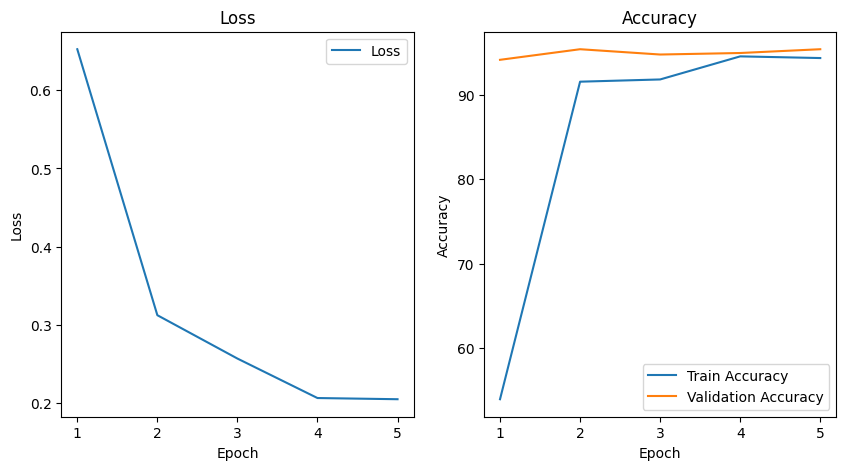

In [ ]:
# Initialize the model with a smaller hidden size
vocab_size = len(itos)
hidden_size = 162  # Choose a smaller hidden size
firstRNN = RNN(vocab_size=vocab_size, hidden_size=hidden_size, n_layers=1)

# Train the model
train_rnn_network(firstRNN, train_loader, val_loader, num_epochs=5, learning_rate=1e-4)


In [ ]:
torch.save(firstRNN.state_dict(), "first_model")

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

For my model 1, I increased the number of layers in the GRU (to 2) hoping for improvement. Since this would increase the number of weights in the network, I also increased the number of epochs to 8.

Here is the result: Epoch 8;  Loss 0.0492; Train Acc 98.3919; Val Acc 96.9372

The performance is great, and it appears not overfitting the training set since the validation accuracy is as good as the training accuracy for most of the epochs (sometimes even better).

For my model 2, I decided to try again with a higher learning rate (5e-4) to avoid getting stuck in local minima and speed up convergence. I also increased the number of epochs to 10.

Here is the result: Epoch 10; Loss 0.0380; Train Acc 98.9390; Val Acc 97.2960

The performance is even better, where loss decrease to 0.08 merely on the 3 epoch (where model 1 took 10). and the final train and val accuracy are both higher than model 1.

For my model 3, I used the below network RNN4 ( used a Concatenate max-pooled and avg-pooled of the GRU output as the input to the fully connected layer) and changed number of opochs to 8 since 10 takes too much time and the performence is not increasing as much after 5 opochs.

Here is the result: Epoch 8; Loss 0.0374; Train Acc 98.8229; Val Acc 97.0404

Even though the final validation accuracy is not as great as model 2, but the loss is better. And model 3 used only 8 epochs instead of 10 opochs like model 2.

For my model 4, I still used RNN4; in addition, I increased the number of epochs to 10 to ensure there is enough of opochs.

Here is the result: Epoch 10; Loss 0.0291; Train Acc 99.1048; Val Acc 97.7578

The run time of model 4 is longer due to the addtional epochs. Performence wise, it is the best out of the four models.

Epoch 1; Loss 0.2877; Train Acc 87.6824; Val Acc 95.7848
Epoch 2; Loss 0.1122; Train Acc 96.2367; Val Acc 97.5785
Epoch 3; Loss 0.0983; Train Acc 96.5849; Val Acc 97.5785
Epoch 4; Loss 0.0843; Train Acc 96.9330; Val Acc 97.8475
Epoch 5; Loss 0.0738; Train Acc 97.3806; Val Acc 96.6816
Epoch 6; Loss 0.0614; Train Acc 98.0106; Val Acc 97.8475
Epoch 7; Loss 0.0553; Train Acc 97.9443; Val Acc 97.7578
Epoch 8; Loss 0.0399; Train Acc 98.5577; Val Acc 98.1166
Epoch 9; Loss 0.0339; Train Acc 98.9058; Val Acc 97.7578
Epoch 10; Loss 0.0291; Train Acc 99.1048; Val Acc 97.7578


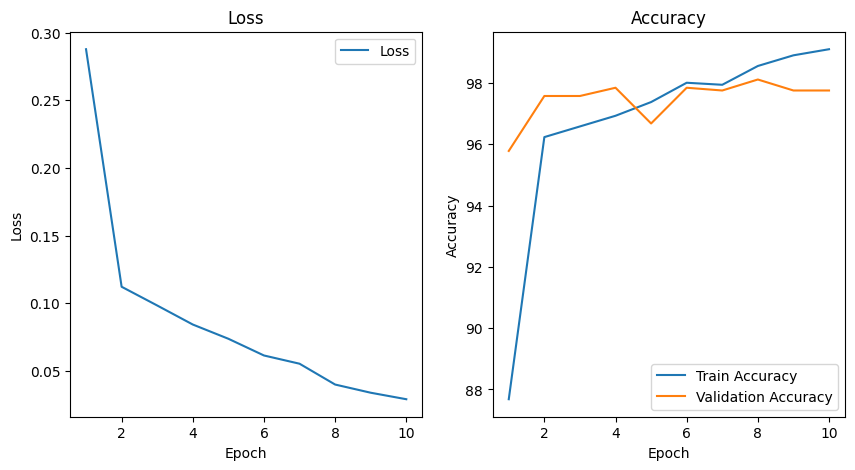

In [ ]:
class RNN4(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(RNN4, self).__init__()

        # Recurrent neural network (GRU)
        self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True)

        # A fully connected layer with twice the hidden size due to concatenation
        self.classifier = nn.Linear(hidden_size * 2, 2)  # *2 to handle concatenated features

    def forward(self, x):
        # One-hot encoding of input indices, assuming x is of shape [batch_size, seq_len]
        one_hot = F.one_hot(x, num_classes=self.rnn.input_size).float()

        # Get the output from the GRU layer
        output, _ = self.rnn(one_hot)  # Shape: [batch_size, seq_len, hidden_size]

        # Max pooling across sequence length (dim=1)
        max_pool = torch.max(output, dim=1)[0]  # Shape: [batch_size, hidden_size]

        # Average pooling across sequence length (dim=1)
        avg_pool = torch.mean(output, dim=1)  # Shape: [batch_size, hidden_size]

        # Concatenate max-pooled and avg-pooled representations
        out = torch.cat((max_pool, avg_pool), dim=1)  # Shape: [batch_size, hidden_size * 2]

        # Classifier: Predict SPAM/HAM
        out = self.classifier(out)  # Shape: [batch_size, 2]

        return out


# Initialize the model with a smaller hidden size
vocab_size = len(itos)
model4 = RNN4(vocab_size=vocab_size, hidden_size=162, n_layers=2)

# Train the model
train_rnn_network(model4, train_loader, val_loader, num_epochs=10, learning_rate=5e-4)


In [ ]:
torch.save(model4.state_dict(), "/content/fourth_model")

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
def evaluate_fpr_fnr(model, loader):
    with torch.no_grad():  # Disable gradient computation for efficiency
        false_positives = 0
        false_negatives = 0
        true_positives = 0
        true_negatives = 0

        for sms, labels in loader:
            # Obtain predictions
            outputs = model(sms)
            _, predicted = torch.max(outputs, 1)

            # Count false positives and true negatives (negative label is 0)
            false_positives += ((predicted == 1) & (labels == 0)).sum().item()
            true_negatives += ((predicted == 0) & (labels == 0)).sum().item()

            # Count false negatives and true positives (positive label is 1)
            false_negatives += ((predicted == 0) & (labels == 1)).sum().item()
            true_positives += ((predicted == 1) & (labels == 1)).sum().item()

        # Calculate FPR and FNR
        fpr = false_positives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0
        fnr = false_negatives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

        print(f"False Positive Rate (FPR): {fpr:.4f}")
        print(f"False Negative Rate (FNR): {fnr:.4f}")


# Run the evaluation on your final model
evaluate_fpr_fnr(model4, val_loader)


False Positive Rate (FPR): 0.0145
False Negative Rate (FNR): 0.0738


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

With false negatives, the spam messages would show as non-spam to the user, which would just take up space in the user's message inbox.
With false positives, the non-spam messages would show as spam message, which could cause the user's to miss potentially important information.

With false negatives, the spam messages would show as non-spam to the user, which would just take up space in the user's message inbox. This would be  annoying to users, who have to deletie the spam message themselves.

With false positives, the non-spam messages would show as spam message, which could cause the user's to miss potentially important information.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
print("The final test accuracy is {}.".format(get_accuracy(model4, test_loader)))

The final test accuracy is 97.66816143497758.


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
evaluate_fpr_fnr(model4, test_loader)

False Positive Rate (FPR): 0.0124
False Negative Rate (FNR): 0.0933


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"

# Step 1: Convert the message to indices
indices = [stoi[char] for char in msg if char in stoi]  # Ignore characters not in the vocabulary

# Step 2: Convert indices to a tensor and add a batch dimension
input_tensor = torch.tensor(indices).unsqueeze(0)  # Shape: [1, seq_len]

# Step 3: Pass the tensor through the model to get logits
with torch.no_grad():  # Disable gradient calculation for inference
    logits = model4(input_tensor)

# Step 4: Apply softmax to get probabilities
probs = F.softmax(logits, dim=1)

# Step 5: Extract and print the spam probability
spam_probability = probs[0, 1].item()  # Assuming index 1 corresponds to SPAM
print(f"Probability that the message is spam: {spam_probability:.4f}")


Probability that the message is spam: 0.0186


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

There are many exiting methods to detect spam messages/emails; in addition, this topic also had many years to resaerch. Companies like Google and Microsoft have well tested, advanced spam blocking engines that operate in places such as their email services. Even though from time to time there is missclassification, but overall they work very well. Hence, I believe spam detection is a relatively easy tasks, especially when compared to tasks such as generating novel images/text, and medical condition detection, etc.

A simple baseline model that we could build is to make a list of commonly used punctuation, words, and attached links format (e.g. lots of spam message have links that starts with 3 numbers then 2 letters) from the training set or experts. The list could then be used to classify other messages as spam if there are a certain amount of elements from that list used in the message. For example, we can scan incoming emails for suspicious words (ex. "free" or "prince") and decision if it should be considered as spam.
